# (A) Dependencies

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# (B) Dataset

### Downloading the dataset via kaggle api
- [Kaggle  Dataset](https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset)

In [3]:
# Download kaggle api
!pip install -q kaggle

In [4]:
# Creat the convenient dir for token. (The system will seach this dir)
! mkdir ~/.kaggle

- Upload your kaggle token
- For creating a token
  - Sign in your Kaggle account,
  - Open Account section from  your icon menu
  - Scroll to API section
  -  Click on __Create New API Token__
     - It will download kaggle.json file on your machine. 
  - Upload this kaggle.json file into your working directory on your google colab session.
  - Run floowing codes

In [5]:
# upload your kaggle token to download dataset.
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [6]:
# Copy the json file into correct path, then remove the firt one it
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [7]:
# Set the token can't readable for other user if you save it somewhere
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Download your data "Competition-name"
#! kaggle competitions download -c 'competition-name'
!kaggle datasets download -d aadityasinghal/facial-expression-dataset

 84% 51.0M/60.7M [00:00<00:00, 132MB/s]
100% 60.7M/60.7M [00:00<00:00, 131MB/s]


In [9]:
!unzip facial-expression-dataset

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

In [10]:
!ls

Basic_EmotionModel.zip	       sample_data	  test
facial-expression-dataset.zip  sample_images.zip  train


## Loading the dataset

In [42]:
train_path = "train/train"
test_path = "test/test"

batch_size = 128
lr=0.01 # 0.001 #  =0.0001

In [43]:
# loading &80 of train data as train
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  label_mode = "categorical",
  validation_split=0.2,
  seed=123,
  subset="training",
  batch_size=batch_size)

# loading &20 of train data as validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  label_mode = "categorical",
  validation_split=0.2,
  seed=123,
  subset="validation",
  batch_size=batch_size)

# loading test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  label_mode = "categorical",
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


## Visualating the data

#### Showing the images

In [44]:
class_names = train_ds.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

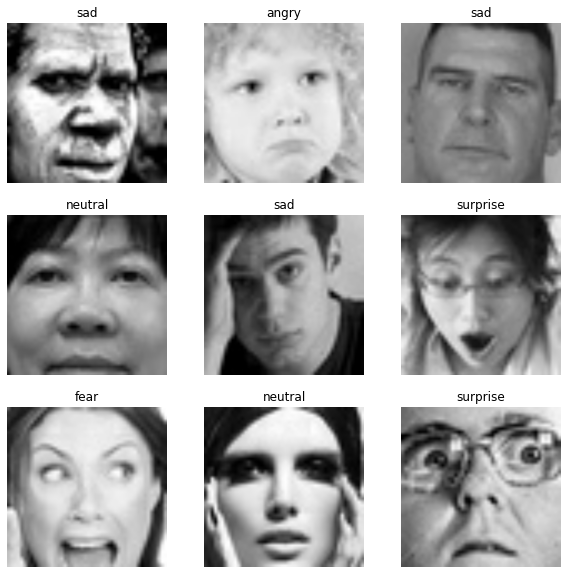

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, label_id in train_ds.take(1):
  for i in range(9):

    id = np.argmax(label_id[i])
    
    # finding out corresponding class name
    label = class_names[id]
    img_shape = images[i].numpy().shape


    # plotting the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")

In [46]:
img_shape

(256, 256, 3)

### Extracting the frequencies of the Classes

In [47]:
# Compute class weights
num_classes = len(class_names)

In [48]:
def get_class_count(dataset, counts):

  for images, labels in dataset: 
    for label in labels.numpy():
      
      # converting the one-hot representation
      idx = np.argmax(label)
      
      # counting the class
      counts[idx] += 1

  return counts

In [17]:
# Defining the collectors
train_class_counts = np.zeros(num_classes)
val_class_counts = np.zeros(num_classes)
test_class_counts = np.zeros(num_classes)

# Finding out the frequencies per class
train_class_counts = get_class_count(train_ds, train_class_counts)
val_class_counts = get_class_count(val_ds, val_class_counts)
test_class_counts = get_class_count(test_ds, test_class_counts)

# total count
total_counts = [train + val + test 
                for train, val, test in 
                zip(train_class_counts, val_class_counts, test_class_counts)
]


In [18]:
counsts = [train_class_counts, val_class_counts, test_class_counts, total_counts]
counsts[-1]

[4953.0, 547.0, 5121.0, 8989.0, 6198.0, 6077.0, 4002.0]

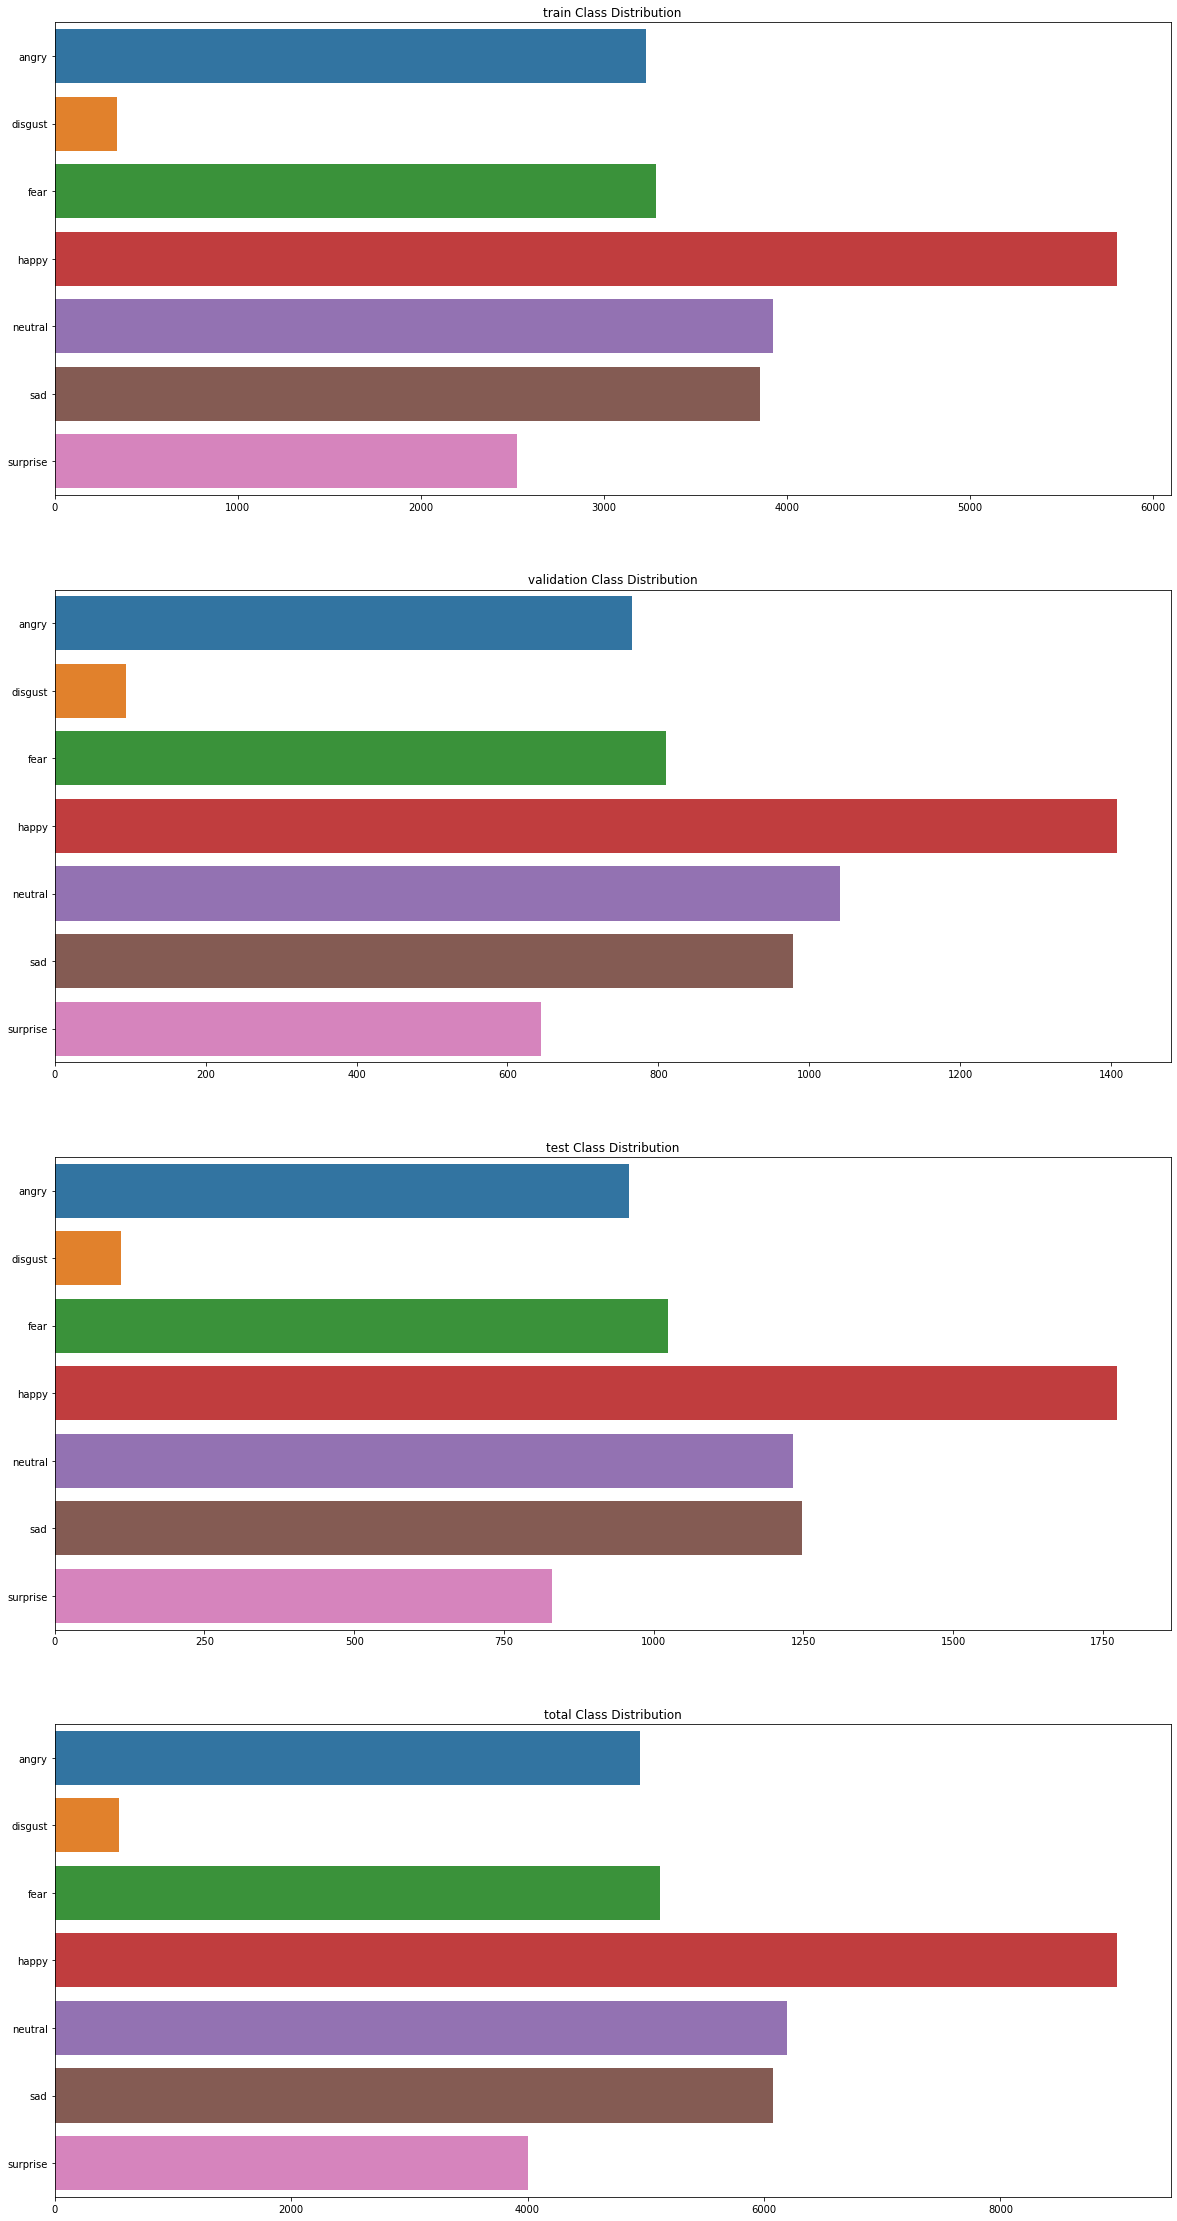

In [27]:
titles = [f"{d} Class Distribution" for d in ["train", "validation", "test", "total"] ]
plt.figure(figsize=(20,40))
for i, cnts in enumerate(counsts):
  plt.subplot(4,1,i+1)
  sns.barplot(y=class_names, x=cnts);
  plt.title(titles[i])

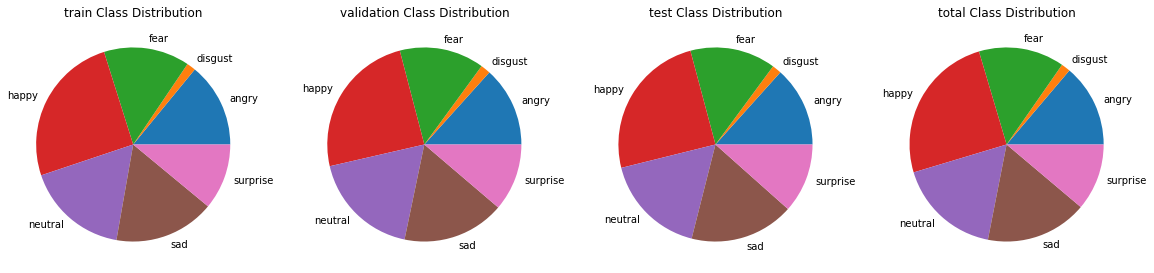

In [28]:
titles = [f"{d} Class Distribution" for d in ["train", "validation", "test", "total"] ]
plt.figure(figsize=(20,40))
for i, cnts in enumerate(counsts):
  plt.subplot(1,4,i+1)
  plt.pie(cnts, labels =class_names);
  plt.title(titles[i])

# (C) Pre-processing the dataset

#### Pre-processing 

In [49]:
img_height, img_width = 64,64
AUTOTUNE = tf.data.AUTOTUNE

In [50]:
def pre_processing(image, label, is_resize=True , new_size=(64,64)):
  
  # Cast the image to tf.float32
  image = tf.cast(image, tf.float32)

  if is_resize:
    # resizing the image
    image = tf.image.resize(image, new_size)

  # scaling the images
  #x = tf.keras.layers.Rescaling(1./255)(image)
  image /= 255.0
  
  return image, label

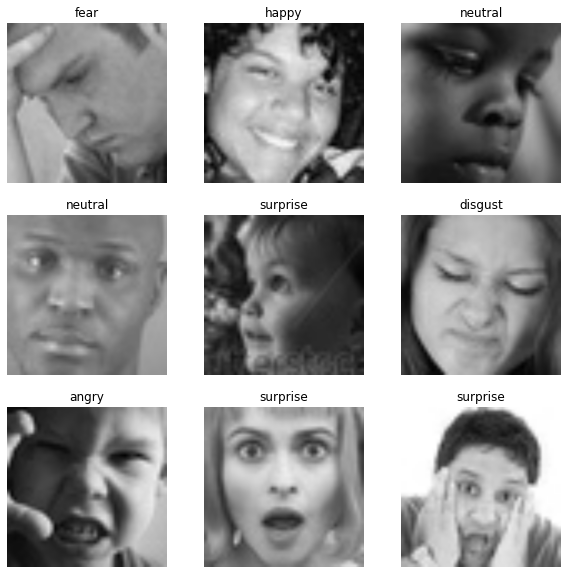

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, label_id in train_ds.take(1):
  for i in range(9):

    id = np.argmax(label_id[i])
    
    # finding out corresponding class name
    label = class_names[id]
    img_shape = images[i].numpy().shape


    # plotting the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")

### Data Augmentation

#### Util Function 

In [52]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential(
  [
    #layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    #layers.RandomZoom(0.2),
    #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    #layers.RandomContrast(factor=0.2),
    #layers.RandomBrightness(factor=0.2),
    #layers.GaussianNoise(0.1),
    #layers.CenterCrop(height=224, width=224),
    #layers.Rescaling(1./255),
    #layers.Normalization(mean=[0.485, 0.456, 0.406], stddev=[0.229, 0.224, 0.225]),
  ]
)

#### visualizating the data augmentation

In [53]:
train_ds.class_names # info.features["label"].names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

##### util functions

In [95]:
def get_a_sample(train_ds, class_names, is_onehot=False):
  
  sample_data = {}
  is_collected = {class_name : False for class_name in class_names}
  
  for image, class_name in train_ds.unbatch().take(len(train_ds)):
    
     # type casting
    class_name = int(np.argmax(class_name)) if is_onehot else int(class_name) 

    # collecting a sample per label
    if class_name not in sample_data.keys():
      sample_data[class_name] = image
      is_collected[class_name] = True 
    
    # check whether collected all classes
    if all(is_collected.values()):
      break

  return sample_data

def augment_per_class(sample_data, ordered_class_names, aug_size = 8, figsize=(30,30), is_processed=False):
  rs, cs = len(sample_data), aug_size+1
  plt.figure(figsize=figsize)

  for row_id, class_name in enumerate(ordered_class_names):
    # extracting the image
    image = sample_data[int(class_name)]
    image, _ =  pre_processing(image, 0) if not is_processed else (image, 0 )


    # plotting the original image in the first axis
    first_col_on_cur_row = row_id*cs + 1
    plt.subplot(rs, cs , first_col_on_cur_row)
    plt.imshow(np.uint8(image)) # astype("uint8"),
    plt.title(f"Original Image of {class_name} class")
    plt.axis("off")


    for col_id in range(1, cs):
        
        # augmenting same image 
        data = {"image":np.array(image)}
        aug_img = data_augmentation(image)
        # plotting 
        cur_col = first_col_on_cur_row + col_id 
        plt.subplot(rs, cs ,  cur_col)
        plt.imshow(np.uint8(aug_img))
        plt.axis("off")
        

In [89]:
import os 
import cv2

def save_sample_data(sample_data, path="sample_images"):
  
  if not os.path.exists(path): os.mkdir(path)

  for name, image in  sample_data.items():
    label = class_names[int(name)]
    file_name = os.path.join(path, f"{str(label)}.png")
    image = np.uint8(image) #* 255

    cv2.imwrite(file_name, image)  
  

##### Demostration

In [56]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [75]:
sample_data = get_a_sample(train_ds, class_names, is_onehot=True)

In [76]:
sample_data.keys()

dict_keys([0, 5, 6, 2, 4, 3, 1])

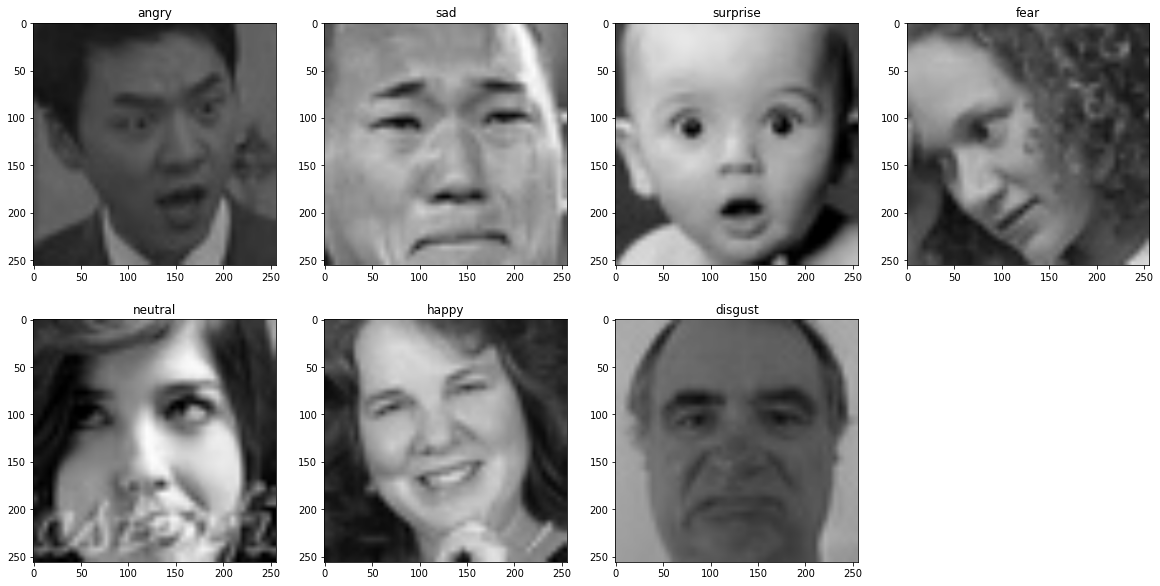

In [77]:
rs, cs = len(sample_data)//4+1, 4
plt.figure(figsize=(cs*5, rs*5))
for i, (l_i, image) in enumerate(sample_data.items()):
  
  # udjusting the data
  l = class_names[l_i]
  
  # plotting the image
  plt.subplot(rs, cs, i+1)
  plt.imshow(np.uint8(image))
  plt.title(str(l))

In [90]:
save_sample_imgs = "sample_images"
save_sample_data(sample_data, save_sample_imgs)

In [91]:
os.system(f"zip -r {save_sample_imgs}.zip {save_sample_imgs}")

0

In [92]:
from google.colab import files
files.download(f"{save_sample_imgs}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [93]:
sample_data.keys()

dict_keys([0, 5, 6, 2, 4, 3, 1])

In [94]:
sample_data[0].shape

TensorShape([256, 256, 3])

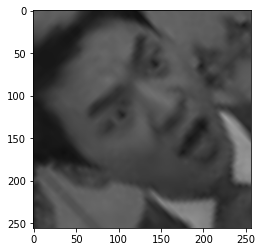

In [86]:
ex = data_augmentation(np.expand_dims(sample_data[0],axis=0))[0]
plt.imshow(np.uint8(ex))

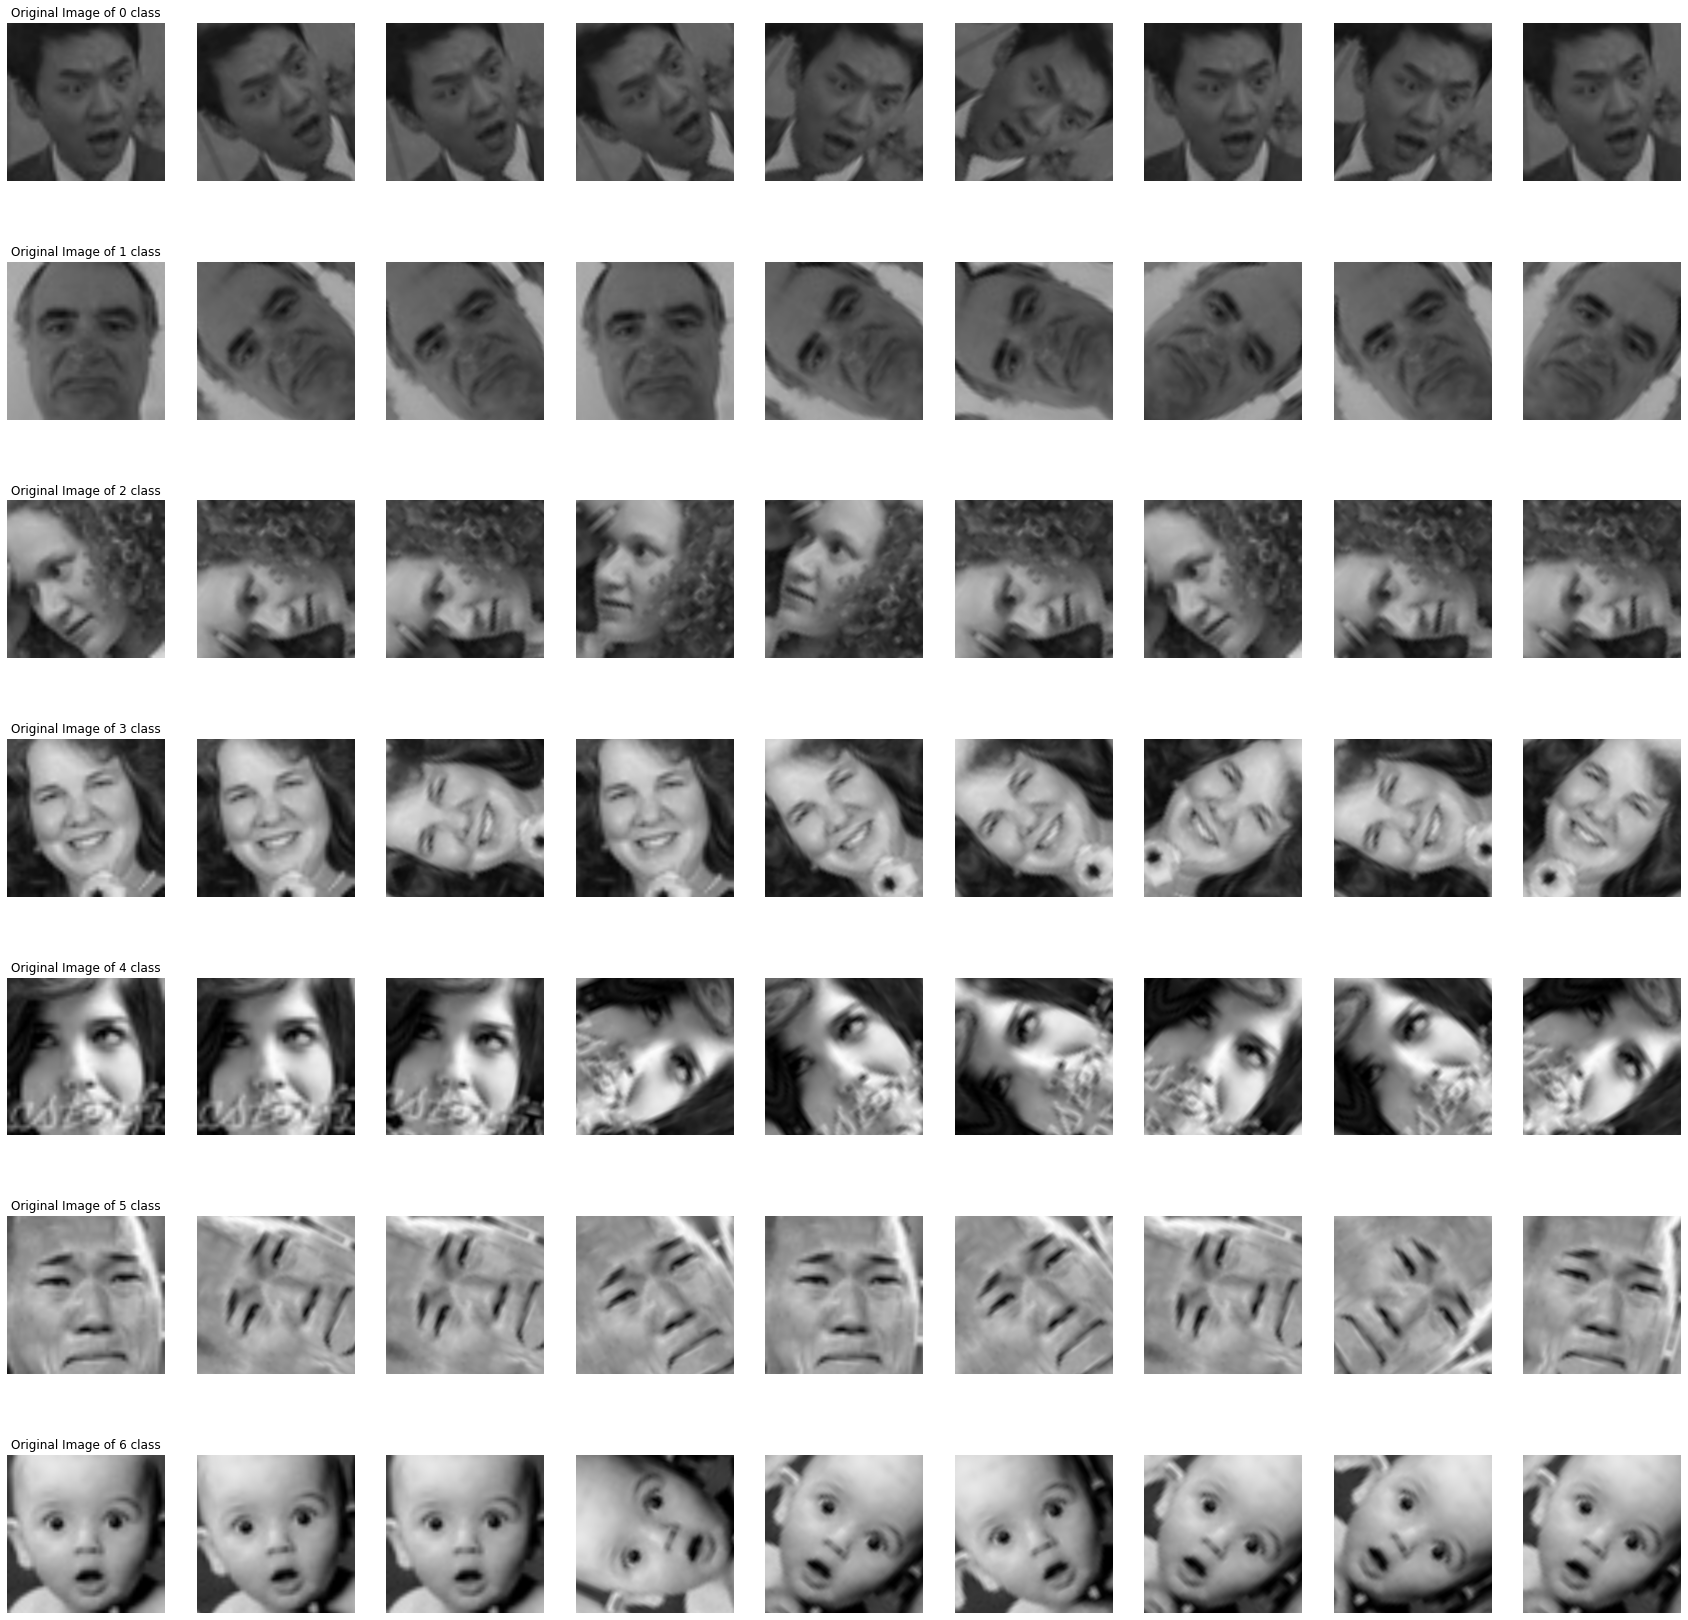

In [96]:
augment_per_class(sample_data, range(len(class_names)), is_processed=True);

### Implementing the processes

#### Preprocessing

In [32]:
# Pre-processing the data
train_ds = train_ds.map(pre_processing)
val_ds = val_ds.map(pre_processing)
test_ds = test_ds.map(pre_processing)

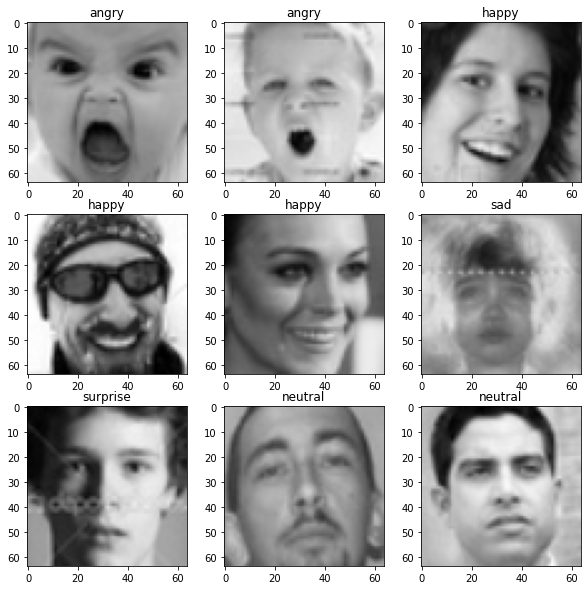

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, id) in enumerate(train_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image) 
    plt.title(class_names[np.argmax(id)])

#### Augmentation

In [34]:
#train_ds_spare= train_ds

In [35]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [36]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

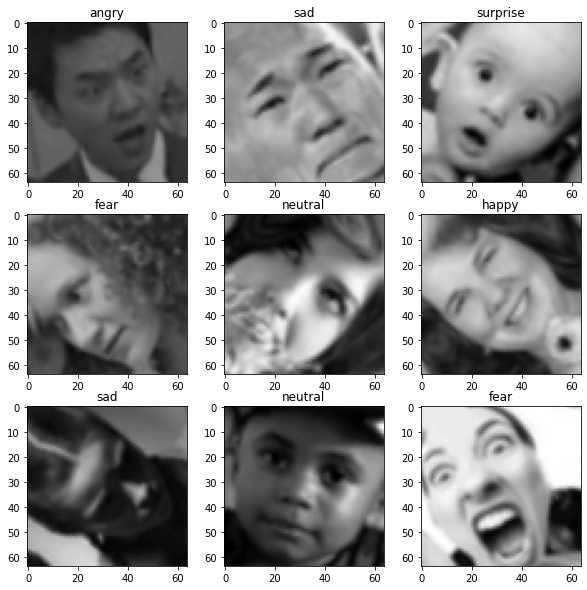

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, id) in enumerate(train_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image) 
    plt.title(class_names[np.argmax(id)])

#### Performance Configuration 

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

# processing the dataset & performance configuration
train_ds = train_ds.shuffle(len(train_ds)).cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [39]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [40]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [41]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

# (D) Modelling

### Basic Modelling

#### Architecture

In [44]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
# Creating a Sequential Model and adding the layers

# input layer
input = Input(shape=(64, 64, 3))

# 1. conv block
x = Conv2D(128, kernel_size=(3,3))(input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# 2. conv block
x = Conv2D(256, kernel_size=(3,3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# 3. conv block
x = Conv2D(512, kernel_size=(3,3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# 4. conv block
x = Conv2D(512, kernel_size=(3,3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# fully connected layer
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

# classifier Dense
output = Dense(len(class_names), activation="softmax")(x)


# Connecting the model
model = Model(input, output)

In [45]:
model.compile(optimizer='adam',  loss='CategoricalCrossentropy',  metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                       

#### Callbacks

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

# Temporary save paths
checkpoint_path = "Temporary_Basic_ModelCheckpoint.h5"
tb_log_dir = "./logs"

In [47]:
callbacks = [
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    #EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    CSVLogger(filename='basic_training.log'),
]

#### Training

In [48]:
history = model.fit(train_ds, validation_data = val_ds, callbacks=callbacks,  epochs=100)  # callbacks=callbacks,

Epoch 1/100
180/180 [==============================] - ETA: 0s - loss: 1.8575 - accuracy: 0.2332
Epoch 1: val_loss improved from inf to 1.79290, saving model to Temporary_Basic_ModelCheckpoint.h5
180/180 [==============================] - 58s 100ms/step - loss: 1.8575 - accuracy: 0.2332 - val_loss: 1.7929 - val_accuracy: 0.2479
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 1.8008 - accuracy: 0.2473
Epoch 2: val_loss improved from 1.79290 to 1.75894, saving model to Temporary_Basic_ModelCheckpoint.h5
180/180 [==============================] - 18s 101ms/step - loss: 1.8008 - accuracy: 0.2473 - val_loss: 1.7589 - val_accuracy: 0.2540
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 1.7819 - accuracy: 0.2633
Epoch 3: val_loss did not improve from 1.75894
180/180 [==============================] - 18s 98ms/step - loss: 1.7819 - accuracy: 0.2633 - val_loss: 1.7641 - val_accuracy: 0.2846
Epoch 4/100
180/180 [==============================] - ETA:

In [50]:
model.evaluate(test_ds)

57/57 [==============================] - 12s 173ms/step - loss: 1.7036 - accuracy: 0.4709


[1.703567385673523, 0.47088325023651123]

#### Visualiting Training History

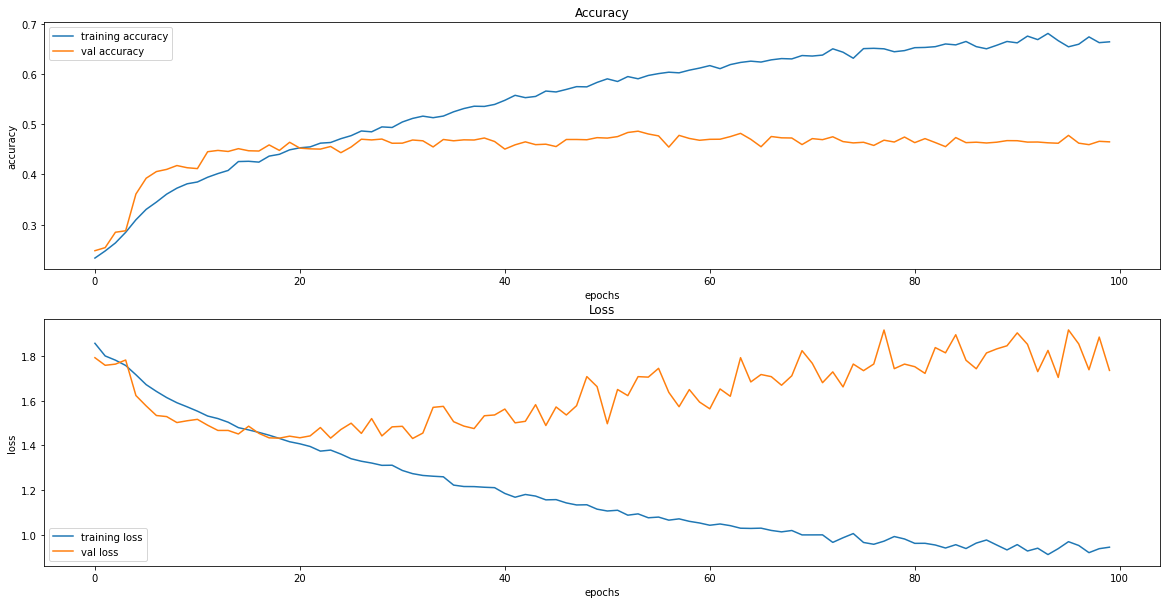

In [51]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### Downloading the basic model

##### Save the best model

In [52]:
# Load the best weights
model.load_weights(checkpoint_path)

# best_model = tf.keras.models.load_model('saved_model/my_model') # best_model_save_path

In [53]:
model.evaluate(val_ds)

45/45 [==============================] - 1s 26ms/step - loss: 1.4309 - accuracy: 0.4684


[1.4308947324752808, 0.4683853089809418]

In [54]:
from datetime import datetime

best_model_save_path = f"Basic_EmotionModel" 
model.save(best_model_save_path)

##### Select the model path

In [55]:
best_model_save_path

'Basic_EmotionModel'

##### Zip the model

In [56]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path

In [57]:
import os
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

##### Download the model

In [58]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transfer Learning

#### Base Model

In [105]:
base_model_params = {
    "input_shape":(64, 64, 3),
    "include_top":False,
    "weights":'imagenet'
}

# Load a pre-trained model
base_models = {
    "MobileNetV2":tf.keras.applications.MobileNetV2(**base_model_params),
    "VGG16":tf.keras.applications.VGG16(**base_model_params),
    "ResNet50":tf.keras.applications.ResNet50(**base_model_params),
    "EfficientNetB0":tf.keras.applications.EfficientNetB0(**base_model_params),

}

In [142]:
#base_model = tf.keras.applications.MobileNetV2(**base_model_params)
base_model = base_models["MobileNetV2"]

# Freeze the base model
base_model.trainable = False

In [143]:
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',  loss='CategoricalCrossentropy',  metrics=['accuracy'])

In [144]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_14  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_40 (Dense)            (None, 256)               327936    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 64)                16448     
                                                                 
 dense_42 (Dense)            (None, 7)               

#### Callbacks

In [145]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))

# Temporary save paths
checkpoint_path = "TemporaryModel_ModelCheckpoint.h5"
tb_log_dir = "./logs"

In [146]:
callbacks = [
    #LearningRateScheduler(step_decay),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    CSVLogger(filename='training.log'),
    #LambdaCallback(on_epoch_end=print_current_lr)
]

#### Training

In [147]:
# Train the model
history = model.fit(train_ds, validation_data = val_ds, callbacks=callbacks, epochs=150) #callbacks=callbacks,

Epoch 1/150
178/180 [============================>.] - ETA: 0s - loss: 1.7496 - accuracy: 0.2976
Epoch 1: val_loss improved from inf to 1.65474, saving model to TemporaryModel_ModelCheckpoint.h5
180/180 [==============================] - 9s 31ms/step - loss: 1.7482 - accuracy: 0.2978 - val_loss: 1.6547 - val_accuracy: 0.3526
Epoch 2/150
179/180 [============================>.] - ETA: 0s - loss: 1.6465 - accuracy: 0.3480
Epoch 2: val_loss improved from 1.65474 to 1.62232, saving model to TemporaryModel_ModelCheckpoint.h5
180/180 [==============================] - 4s 24ms/step - loss: 1.6460 - accuracy: 0.3481 - val_loss: 1.6223 - val_accuracy: 0.3632
Epoch 3/150
178/180 [============================>.] - ETA: 0s - loss: 1.6015 - accuracy: 0.3681
Epoch 3: val_loss improved from 1.62232 to 1.59880, saving model to TemporaryModel_ModelCheckpoint.h5
180/180 [==============================] - 4s 25ms/step - loss: 1.6006 - accuracy: 0.3686 - val_loss: 1.5988 - val_accuracy: 0.3787
Epoch 4/150

#### Visualiting Training History

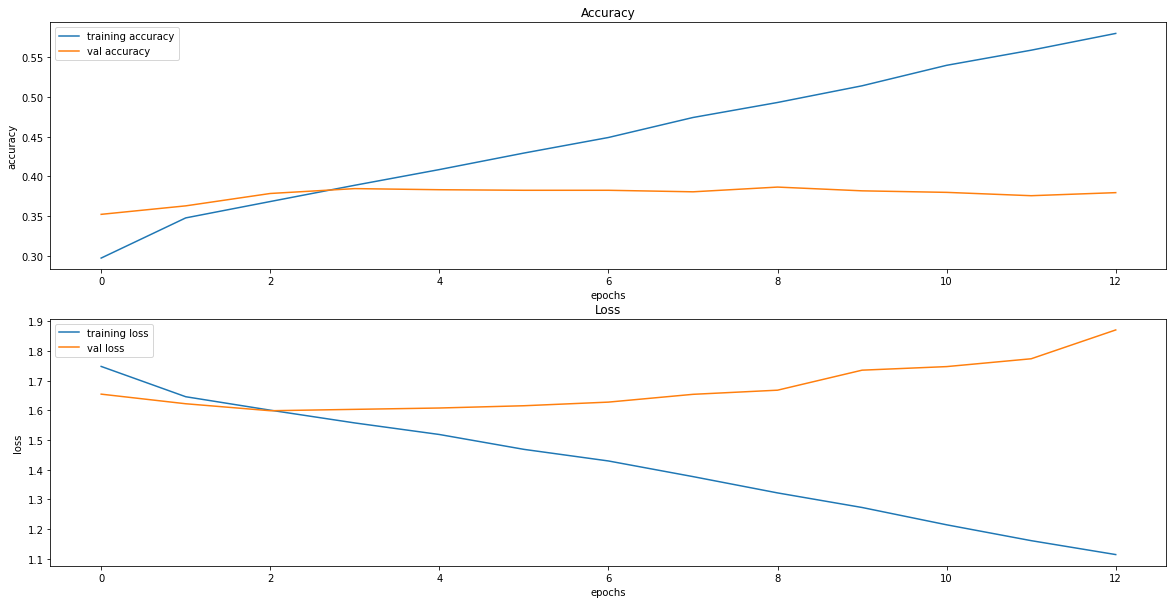

In [148]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### Model Saving

##### Save the best model

In [ ]:
# Load the best weights
model.load_weights(checkpoint_path)

# best_model = tf.keras.models.load_model('saved_model/my_model') # best_model_save_path

In [ ]:
from datetime import datetime


now = datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
best_model_save_path = f"{model.name}_{now}" 


model.save(best_model_save_path)

##### Downloading the models

###### Select the model path

In [ ]:
model_path = best_model_save_path
all_models = best_model_save_path #"/content/Models"
best_model_save_path

'best_model_02-09-2023_14:45:40'

###### Zip the model

In [ ]:
# Zipping the model to download
dst, src = f"{best_model_save_path}.zip", best_model_save_path
os.system(f"zip -r {dst} {src}")

0

###### Download the zipped file into the local

In [ ]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (F) Deployment Web app

In [1]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 K

In [2]:
!unzip sample_images.zip

Archive:  sample_images.zip
   creating: sample_images/
  inflating: sample_images/angry.png  
  inflating: sample_images/happy.png  
  inflating: sample_images/sad.png   
  inflating: sample_images/surprise.png  
  inflating: sample_images/fear.png  
  inflating: sample_images/neutral.png  
  inflating: sample_images/disgust.png  


In [3]:
!unzip Basic_EmotionModel.zip

Archive:  Basic_EmotionModel.zip
   creating: Basic_EmotionModel/
   creating: Basic_EmotionModel/variables/
  inflating: Basic_EmotionModel/variables/variables.index  
  inflating: Basic_EmotionModel/variables/variables.data-00000-of-00001  
 extracting: Basic_EmotionModel/fingerprint.pb  
  inflating: Basic_EmotionModel/saved_model.pb  
  inflating: Basic_EmotionModel/keras_metadata.pb  
   creating: Basic_EmotionModel/assets/


In [4]:
import gradio as gr
import tensorflow as tf
from glob import glob
import cv2
import os
import numpy as np

model_path = "Basic_EmotionModel"
model = tf.keras.models.load_model(model_path)
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
labels 

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
def process_image(image):
    # Convert into tensor
    image = tf.convert_to_tensor(image)

    # Cast the image to tf.float32
    image = tf.cast(image, tf.float32)
    
    # Resize the image to img_resize
    image = tf.image.resize(image, (64,64))
    
    # Normalize the image
    image /= 255.0
    
    # Return the processed image and label
    return image

def predict(image):

  # Pre-procesing the data
  images = process_image(image)

  # Batching
  batched_images = tf.expand_dims(images, axis=0)
  
  prediction = model.predict(batched_images).flatten()
  confidences = {labels[i]: np.round(float(prediction[i]), 7) for i in range(len(labels))}
  return confidences

In [7]:
demo = gr.Interface(fn=predict, 
             inputs=gr.Image(shape=(32, 32)),
             outputs=gr.Label(num_top_classes=len(labels)),
             examples="sample_images")
             
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>